In [4]:
#data wrangling and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import scipy.stats as stats

#feature engineering packages
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

#feature selection packages
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropConstantFeatures

#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

#modeling evaluation packages
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, auc
from sklearn.metrics import get_scorer

#optimization packages
from sklearn.model_selection import GridSearchCV

## Global Function

In [5]:
#function to look at plots and stats of column with or without outliers
def model_eval(model, X_train, y_train, X_test, y_test, 
               prev_model=None, prev_X_train=None, prev_y_train=None,
               prev_X_test=None, prev_y_test=None):
    '''
    This function takes in a fit model and provides classification evaluation
    metrics on that model. Optionally, a previous model can be supplied to give
    improvement metrics between the current model and the previous model.
    Keyword Arguments:
    - model: A fit model
    - X_train, y_train, X_test, y_test: Training and testing dataframes which
    the "model" stated above was fit on.
    - prev_model: Another fit model
    - prev_X_train, prev_y_train, prev_X_test, prev_y_test: Training and 
    testing dataframes which the previous model was fit on.
    '''
    #current model predictions on testing dataframe
    y_hat_test = model.predict(X_test)
    #get scores of current model on testing dataframe
    recall_model = get_scorer('recall')(model, X_test, y_test).round(2)
    f1_model = get_scorer('f1')(model, X_test, y_test).round(2)
    accuracy_model = get_scorer('accuracy')(model, X_test, y_test).round(2)
    auc_model = get_scorer('roc_auc')(model, X_test, y_test).round(2)
    
    recall_model_train = get_scorer('recall')(model, X_train, y_train).round(2)
    #if statement to check for availability of a previous model and training
    #and testing dataframes
    if prev_model != None:
        if prev_X_train is None:
            #if prevoius model has a different training and testing dataframes
            
            #get previous model predictions and scores
            y_hat_test_prev = prev_model.predict(X_test)

            recall_prev = get_scorer('recall')(prev_model, X_test, y_test).round(2)
            f1_prev = get_scorer('f1')(prev_model, X_test, y_test).round(2)
            accuracy_prev = get_scorer('accuracy')(prev_model, X_test, y_test).round(2)
            auc_prev = get_scorer('roc_auc')(prev_model, X_test, y_test).round(2)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')
            
            #create dataframe comparing current and previous model
            df = pd.DataFrame(index=['Recall','F1','Accuracy','AUC'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model
            df.loc['Recall','Previous Model'] = recall_prev
            df.loc['F1','Current Model'] = f1_model
            df.loc['F1','Previous Model'] = f1_prev
            df.loc['Accuracy','Current Model'] = accuracy_model
            df.loc['Accuracy','Previous Model'] = accuracy_prev
            df.loc['AUC','Current Model'] = auc_model
            df.loc['AUC','Previous Model'] = auc_prev
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)
            df.loc['AUC','Delta'] = (auc_model - auc_prev).round(2)

            display(df)
            print('\n')

            #display current model scores, reports and graphs
            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8))

            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=["NO INJURY",'INJURY'], 
                                  ax=ax[0]);

            plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()
            
            #display previous model graphs
            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8));

            plot_confusion_matrix(prev_model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['NO INJURY','INJURY'], 
                                  ax=ax[0]);

            plot_roc_curve(prev_model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            plt.tight_layout()
        else:
            #if previous model has the same dataframes as current model
            y_hat_test_prev = prev_model.predict(prev_X_test)

            recall_prev = get_scorer('recall')(prev_model, prev_X_test, 
                                               prev_y_test).round(2)
            f1_prev = get_scorer('f1')(prev_model, prev_X_test, 
                                       prev_y_test).round(2)
            accuracy_prev = get_scorer('accuracy')(prev_model, prev_X_test, 
                                                   prev_y_test).round(2)
            auc_prev = get_scorer('roc_auc')(prev_model, prev_X_test, 
                                             prev_y_test).round(2)

            print('MODEL EVAL VS PREVIOUS (TEST)')
            print('=================================================================')

            df = pd.DataFrame(index=['Recall','F1','Accuracy','AUC'], 
                              columns=['Previous Model','Current Model','Delta'])

            df.loc['Recall','Current Model'] = recall_model
            df.loc['Recall','Previous Model'] = recall_prev
            df.loc['F1','Current Model'] = f1_model
            df.loc['F1','Previous Model'] = f1_prev
            df.loc['Accuracy','Current Model'] = accuracy_model
            df.loc['Accuracy','Previous Model'] = accuracy_prev
            df.loc['AUC','Current Model'] = auc_model
            df.loc['AUC','Previous Model'] = auc_prev
            df.loc['Recall','Delta'] = (recall_model - recall_prev).round(2)
            df.loc['F1','Delta'] = (f1_model - f1_prev).round(2)
            df.loc['Accuracy','Delta'] = (accuracy_model - accuracy_prev).round(2)
            df.loc['AUC','Delta'] = (auc_model - auc_prev).round(2)

            display(df)
            print('\n')


            print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
            print('=================================================================')
            print('\n')
            
            print(f'Recall on Training: {recall_model_train}')
            print(f'Recall on Test: {recall_model}')
            print('\n')
            
            print('Classification Reports-------------------------------------------')
            print(classification_report(y_test, y_hat_test))

            print('Test Graphs------------------------------------------------------')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8))

            plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['NO INJURY','INJURY'], 
                                  ax=ax[0]);

            plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            print("PREVIOUS MODEL")
            print('=================================================================')
            fig, ax = plt.subplots(ncols=2, figsize=(15,8));

            plot_confusion_matrix(prev_model, prev_X_test, prev_y_test, cmap='Blues',
                                         normalize='true', 
                                  display_labels=['NO INJURY',"INJURY"], 
                                  ax=ax[0]);

            plot_roc_curve(prev_model, prev_X_test, prev_y_test, 
                           ax=ax[1]).ax_.plot([0,1],[0,1]);
            plt.show()

            plt.tight_layout()
    else:
        #if there is no previous model, get current model metrics and graphs
        print(f"CURRENT MODEL: {'Overfit (Recall)' if recall_model_train - recall_model > .05 else 'Not Overfit (Recall)'}")
        print('=================================================================')
        print('\n')
        print('Classification Reports-------------------------------------------')
        print(classification_report(y_test, y_hat_test))
               
        print('Test Graphs------------------------------------------------------')
        fig, ax = plt.subplots(ncols=2, figsize=(15,8))

        plot_confusion_matrix(model, X_test, y_test, cmap='Blues',
                                     normalize='true', 
                              display_labels=['NO INJURY','INJURY'], 
                              ax=ax[0]);

        plot_roc_curve(model, X_test, y_test, ax=ax[1]).ax_.plot([0,1],[0,1]);
        plt.show()

  
    return

In [50]:
def get_coefficients(model,X_train):
    '''
    Function to get coefficients of logistic regression models from class
    '''
    
    
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
    coeffs['intercept'] = model.intercept_[0]
    return coeffs

In [6]:
X_train_dt = pd.read_csv("crash_train.csv")
X_test_dt = pd.read_csv("crash_test.csv")

In [7]:
X_train_lr_sel = X_train_dt.copy()
X_test_lr_sel = X_test_dt.copy()

In [8]:
y_train = pd.read_csv("crash_y_train.csv")
y_test = pd.read_csv("crash_y_test.csv")


In [9]:
y_train.drop("Unnamed: 0", axis=1, inplace=True)
y_test.drop("Unnamed: 0", axis=1, inplace=True)

In [10]:
X_test_dt.drop("Unnamed: 0", axis=1, inplace=True)
X_train_dt.drop("Unnamed: 0", axis=1, inplace=True)

In [11]:
X_train_dt

,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,SEC_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,SEC_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,SEC_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,...,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,CRASH_HOUR,CRASH_DATE_YR,SEVERELY_INJURED,DEAD
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,1.030341,0.365326,-0.232117,-0.053917
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-3.438021,-0.151950,-0.139534,-0.286127,-0.216070,0.633284,1.568044,-0.291111,-0.232117,-0.053917
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.051112,1.849216,-0.139534,-0.286127,-0.216070,0.633284,0.492638,0.365326,-0.232117,-0.053917
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,-1.478939,-0.947549,-0.232117,-0.053917
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,0.313404,-0.291111,-0.232117,-0.053917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82794,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,-0.762002,-0.947549,-0.232117,-0.053917
82795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.744541,-0.151950,-0.139534,-0.286127,5.133978,-0.958654,1.030341,-0.291111,4.308174,-0.053917
82796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,-1.478939,1.678201,-0.232117,-0.053917
82797,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.335848,-0.151950,-0.139534,1.699206,-0.216070,0.633284,0.313404,1.021763,-0.232117,-0.053917


# Complete jupyter nb

## Logistic Regression

### Model 2

In [12]:
lr_2 = LogisticRegression()
lr_2.fit(X_train_lr_sel, y_train)

c:\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

#### Model Evaluation

### Model 3

In [13]:
lr_3 = LogisticRegression()

In [14]:
params_3 = {"C": [0.001, 0.01, 0.1, 1, 1e7, 1e8, 1e9, 1e10],
           "penalty": ["l1", "l2"], 
           "solver":["liblinear"]}

In [15]:
lr_3_gridsearch = GridSearchCV(lr_3, params_3,
                               scoring="recall", n_jobs=-1, cv=5)
lr_3_gridsearch.fit(X_train_lr_sel, y_train)

c:\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10000000.0, 100000000.0,
                               1000000000.0, 10000000000.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='recall')

#### Model Evaluation

In [16]:
lr_3_gridsearch.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0,0.8,0.8
F1,0,0.83,0.83
Accuracy,0.67,0.89,0.22
AUC,0.51,0.96,0.45




CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.81
Recall on Test: 0.8


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     23838
           1       0.86      0.80      0.83     11648

    accuracy                           0.89     35486
   macro avg       0.88      0.87      0.87     35486
weighted avg       0.89      0.89      0.89     35486

Test Graphs------------------------------------------------------


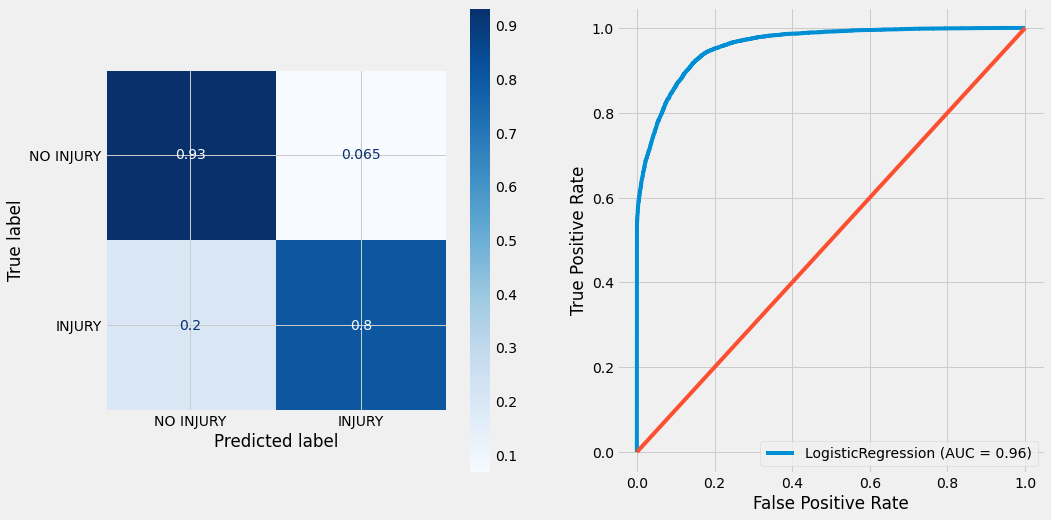

PREVIOUS MODEL


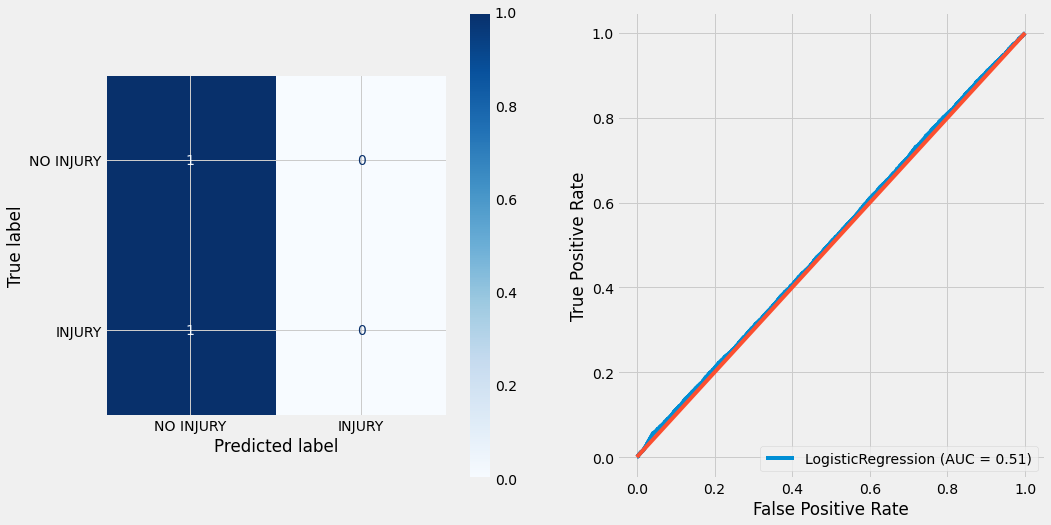

<Figure size 432x288 with 0 Axes>

In [17]:
model_eval(lr_3_gridsearch.best_estimator_, X_train_lr_sel, y_train, X_test_lr_sel, y_test, prev_model=lr_2)

> **Observations** 
> Feature selection did not seem to neagtvely impact the model but reduced the feature count by 21%.

> **Actions**
> See if fizing class imbalance will help the model

### Model 4

In [18]:
 lr_4 = LogisticRegression(class_weight="balanced")

In [19]:
params_4 = {"C":[.01, 0.1, 1, 1e7, 1e8, 1e9, 1e10],
           "penalty":["l1", "l2"],
           "solver":["liblinear"]}

In [20]:
lr_4_gridsearch = GridSearchCV(lr_4, params_4, scoring="recall", n_jobs=-1, cv=5)
lr_4_gridsearch.fit(X_train_lr_sel, y_train)

c:\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10000000.0, 100000000.0,
                               1000000000.0, 10000000000.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='recall')

In [21]:
lr_4_gridsearch.best_params_

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

#### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.8,0.9,0.1
F1,0.83,0.83,0
Accuracy,0.89,0.88,-0.01
AUC,0.96,0.96,0




CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.9
Recall on Test: 0.9


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     23838
           1       0.76      0.90      0.83     11648

    accuracy                           0.88     35486
   macro avg       0.86      0.88      0.86     35486
weighted avg       0.89      0.88      0.88     35486

Test Graphs------------------------------------------------------


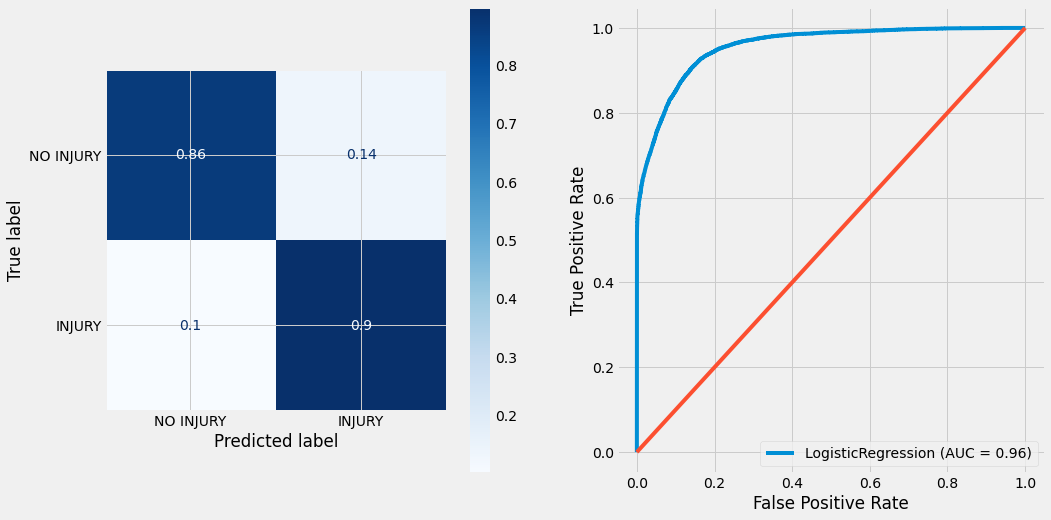

PREVIOUS MODEL


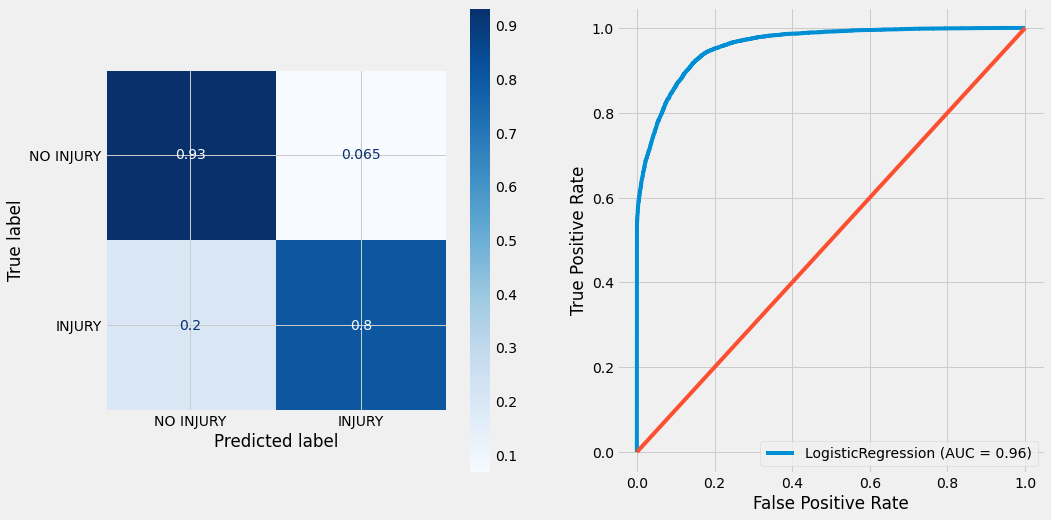

<Figure size 432x288 with 0 Axes>

In [22]:
model_eval(lr_4_gridsearch.best_estimator_, X_train_lr_sel,y_train,
          X_test_lr_sel,y_test,
           prev_model=lr_3_gridsearch.best_estimator_ )

> **Observations**
> Balancing the classes improved the model by increasing the recall score by 5% and increased the accuracy by 1%

### Best LR Model

The besst Logistic Regression model was model #4 which produced the following model performance and important features:

CURRENT MODEL: Not Overfit (Recall)


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     23838
           1       0.76      0.90      0.83     11648

    accuracy                           0.88     35486
   macro avg       0.86      0.88      0.86     35486
weighted avg       0.89      0.88      0.88     35486

Test Graphs------------------------------------------------------


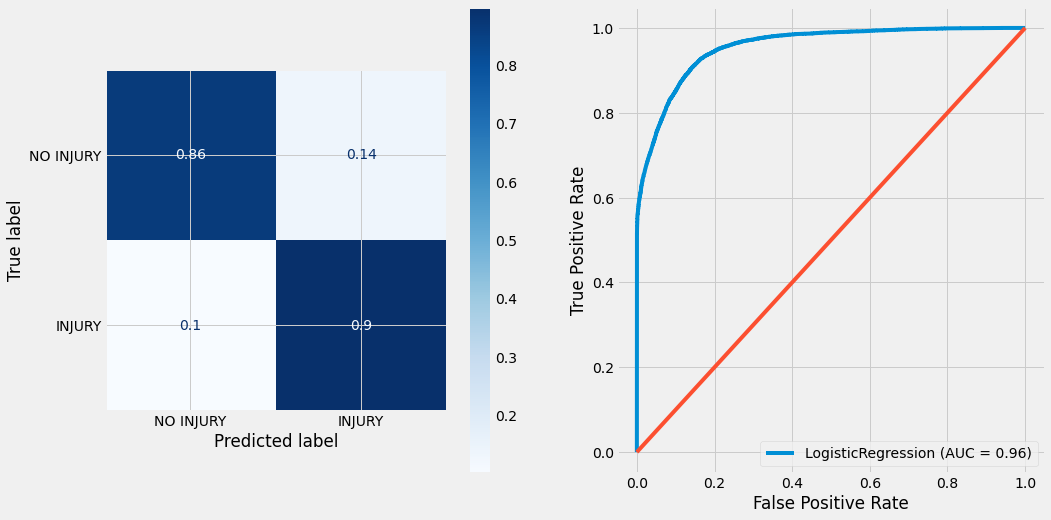

In [46]:
model_eval(lr_4_gridsearch.best_estimator_, 
          X_train_lr_sel, y_train, X_test_lr_sel, 
          y_test)

In [52]:
#find top coefficients
best_coeffs = get_coefficients(lr_4_gridsearch.best_estimator_,X_train_lr_sel)
best_coeffs_pos = best_coeffs.loc[best_coeffs >= 0].sort_values(ascending=False)
best_coeffs_neg = best_coeffs.loc[best_coeffs < 0].sort_values(ascending=True)
best_coeffs_overall = best_coeffs.abs().sort_values(ascending=False)

<AxesSubplot:>

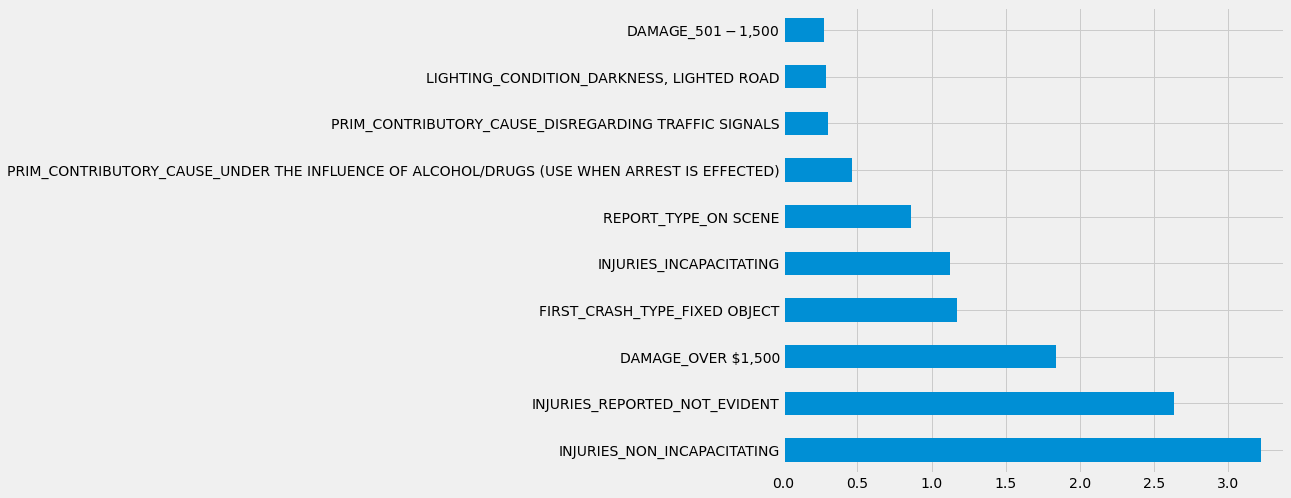

In [56]:
fig = plt.subplots(figsize=(8, 8))
best_coeffs_pos[:10].plot.barh()

<AxesSubplot:>

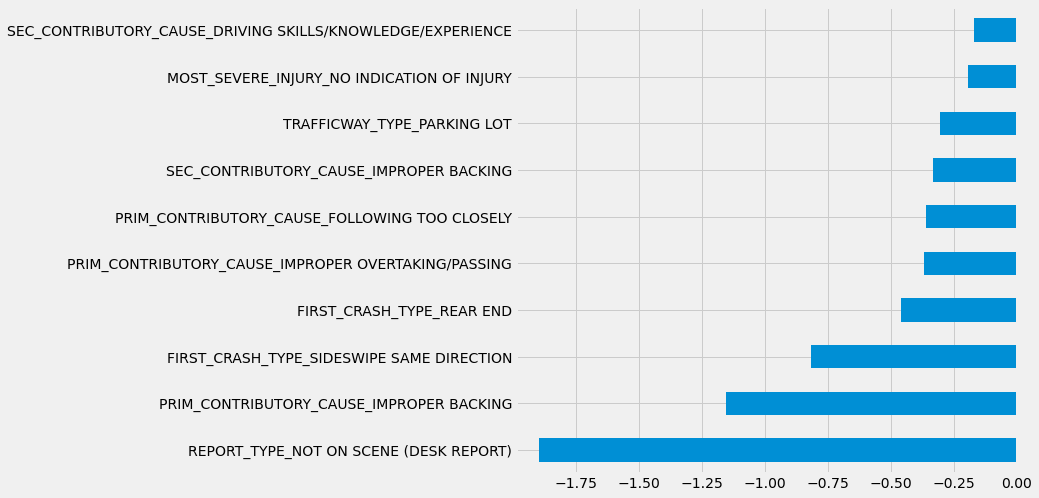

In [53]:
fig = plt.subplots(figsize=(8, 8))
best_coeffs_neg[:10].plot.barh()

## Random Forest

### Model 1

In [23]:
X_train_dt 

,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,SEC_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,SEC_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,SEC_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,...,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,CRASH_HOUR,CRASH_DATE_YR,SEVERELY_INJURED,DEAD
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,1.030341,0.365326,-0.232117,-0.053917
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-3.438021,-0.151950,-0.139534,-0.286127,-0.216070,0.633284,1.568044,-0.291111,-0.232117,-0.053917
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.051112,1.849216,-0.139534,-0.286127,-0.216070,0.633284,0.492638,0.365326,-0.232117,-0.053917
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,-1.478939,-0.947549,-0.232117,-0.053917
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,0.313404,-0.291111,-0.232117,-0.053917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82794,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,-0.762002,-0.947549,-0.232117,-0.053917
82795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.744541,-0.151950,-0.139534,-0.286127,5.133978,-0.958654,1.030341,-0.291111,4.308174,-0.053917
82796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153285,-0.151950,-0.139534,-0.286127,-0.216070,-0.162685,-1.478939,1.678201,-0.232117,-0.053917
82797,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.335848,-0.151950,-0.139534,1.699206,-0.216070,0.633284,0.313404,1.021763,-0.232117,-0.053917


In [24]:
rf_1 = RandomForestClassifier()
rf_1.fit(X_train_dt, y_train)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier()

#### Model Evaluation

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.9,0.79,-0.11
F1,0.83,0.83,0
Accuracy,0.88,0.89,0.01
AUC,0.96,0.96,0




CURRENT MODEL: Overfit (Recall)


Recall on Training: 1.0
Recall on Test: 0.79


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     23838
           1       0.87      0.79      0.83     11648

    accuracy                           0.89     35486
   macro avg       0.88      0.87      0.87     35486
weighted avg       0.89      0.89      0.89     35486

Test Graphs------------------------------------------------------


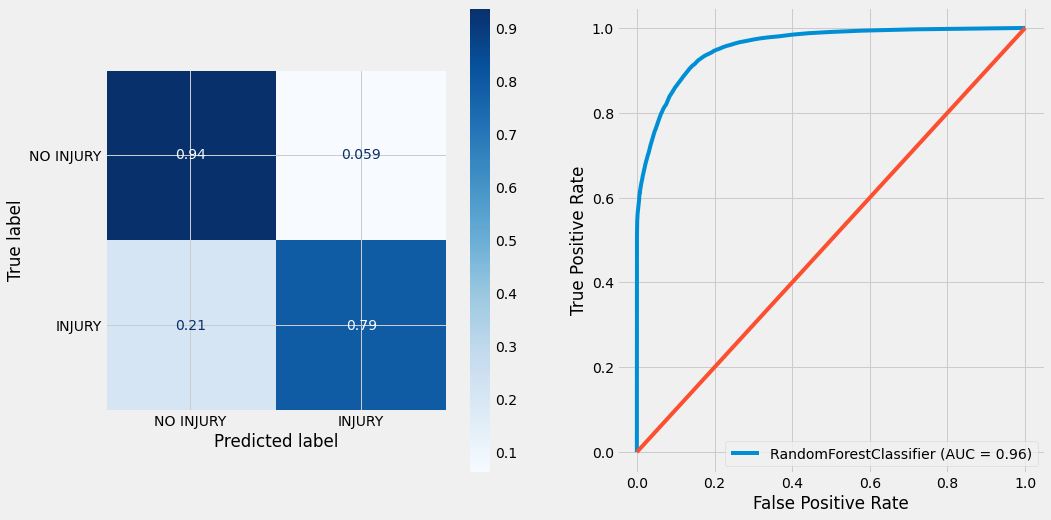

PREVIOUS MODEL


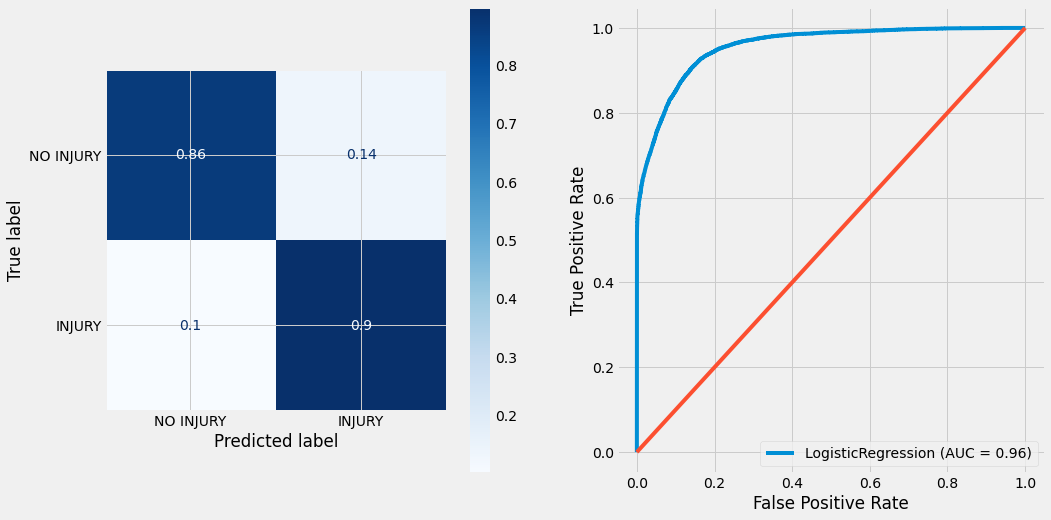

<Figure size 432x288 with 0 Axes>

In [25]:
model_eval(rf_1, X_train_dt, y_train, X_test_dt, y_test, 
            prev_model=lr_4_gridsearch.best_estimator_,
           prev_X_train=X_train_lr_sel,
           prev_y_train=y_train,
            prev_X_test=X_test_lr_sel, prev_y_test=y_test)

### Model 2

In [26]:
rf_2 = RandomForestClassifier()

In [27]:
params = [{"n_estimators":[100, 500, 1000],
          "criterion":["entropy", "gini"],
          "max_features":["auto", "log2"],
          "class_weight":["balanced"],
          "max_depth":[20, 35, 65],
          "min_samples_split":[2, 3],
          "min_samples_leaf":[1, 2, 3]}]

In [28]:
rf_2_gridsearch = GridSearchCV(rf_2, params, scoring="recall", n_jobs=-1, cv=3)
rf_2_gridsearch.fit(X_train_dt, y_train)

c:\python\python37\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['entropy', 'gini'],
                          'max_depth': [20, 35, 65],
                          'max_features': ['auto', 'log2'],
                          'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [2, 3],
                          'n_estimators': [100, 500, 1000]}],
             scoring='recall')

#### Model Evaluation

In [29]:
rf_2_gridsearch.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

MODEL EVAL VS PREVIOUS (TEST)


,Previous Model,Current Model,Delta
Recall,0.79,0.9,0.11
F1,0.83,0.83,0
Accuracy,0.89,0.88,-0.01
AUC,0.96,0.96,0




CURRENT MODEL: Not Overfit (Recall)


Recall on Training: 0.91
Recall on Test: 0.9


Classification Reports-------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     23838
           1       0.78      0.90      0.83     11648

    accuracy                           0.88     35486
   macro avg       0.86      0.89      0.87     35486
weighted avg       0.89      0.88      0.88     35486

Test Graphs------------------------------------------------------


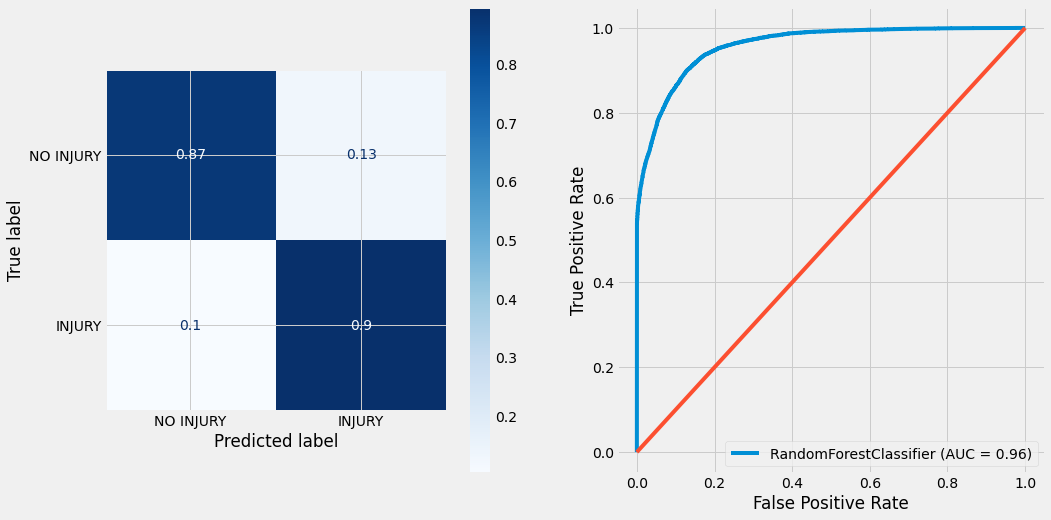

PREVIOUS MODEL


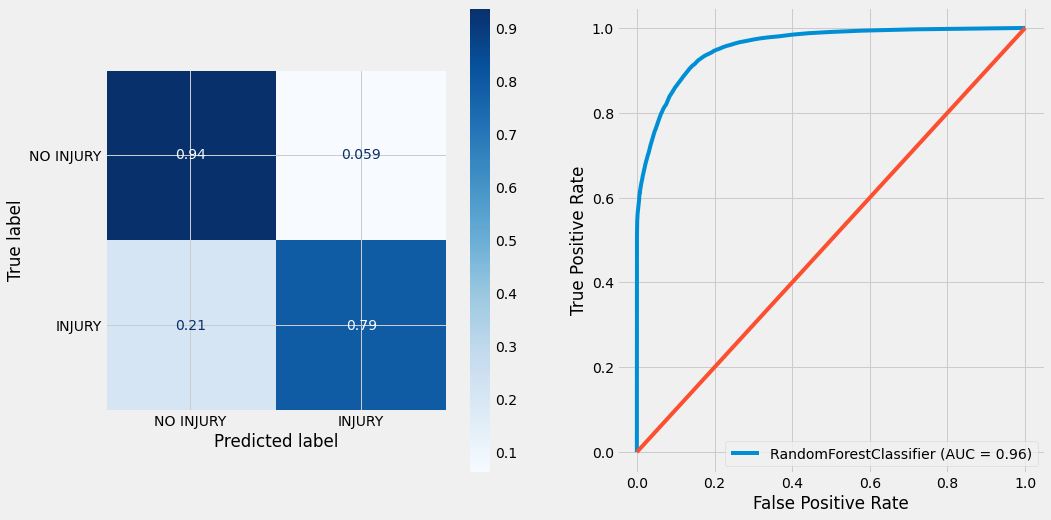

<Figure size 432x288 with 0 Axes>

In [30]:
model_eval(rf_2_gridsearch.best_estimator_, X_train_dt, y_train, X_test_dt, y_test,
           prev_model=rf_1)

> **Observations**
> - The model increased recall by 12% but decreased accucacy by 1%.

In [33]:
rf_2_fi = rf_2_gridsearch.best_estimator_.feature_importances_

In [42]:
rf_2_features = pd.DataFrame(data=rf_2_fi, index=X_train_dt.columns,
                            columns=["Feature Importances"])
rf_2_features_sorted = rf_2_features[:10].sort_values("Feature Importances", ascending=False)

rf_2_features_sorted

,Feature Importances
"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",0.006239
LIGHTING_CONDITION_DAYLIGHT,0.003616
SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,0.000377
LIGHTING_CONDITION_DAWN,0.000254
LIGHTING_CONDITION_DUSK,0.000222
SEC_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,0.000212
SEC_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,0.000155
SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,0.000087
SEC_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,0.000055
SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,0.000030


In [37]:
rf_2_features_sorted

,Feature Importances
"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",0.006239
LIGHTING_CONDITION_DAYLIGHT,0.003616
SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,0.000377
LIGHTING_CONDITION_DAWN,0.000254
LIGHTING_CONDITION_DUSK,0.000222
SEC_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,0.000212
SEC_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,0.000155
SEC_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,0.000087
SEC_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,0.000055
SEC_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,0.000030


<AxesSubplot:xlabel='Feature Importances'>

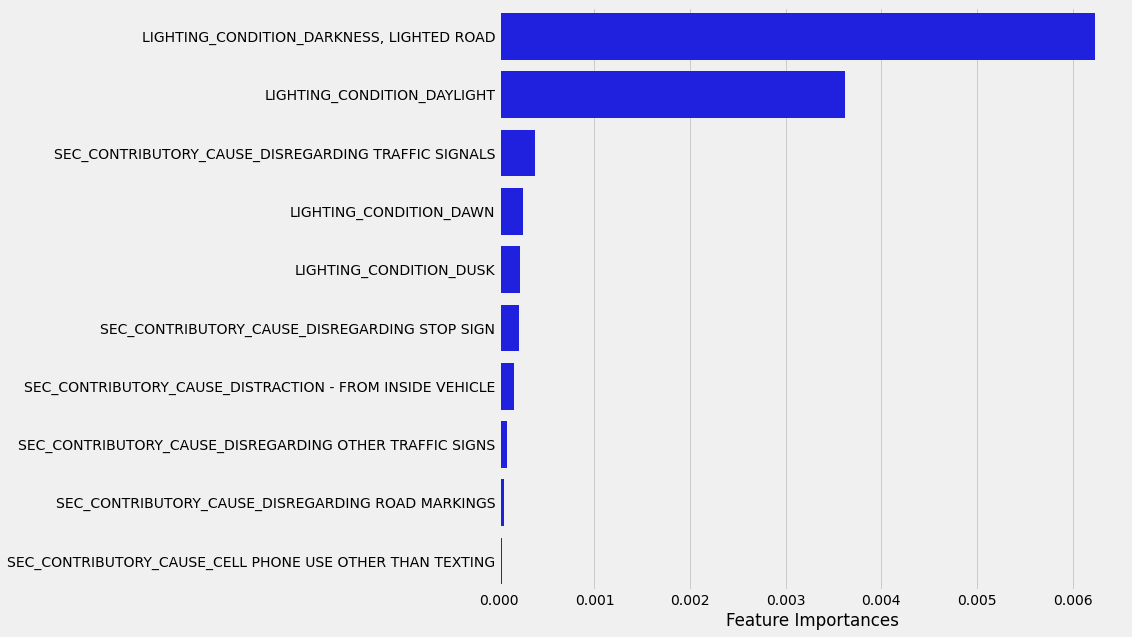

In [39]:
fig, ax= plt.subplots(figsize=(10, 10))
sns.barplot(data=rf_2_features_sorted,
           x=rf_2_features_sorted["Feature Importances"],
           y = rf_2_features_sorted.index, orient="h", color="blue")

# Data Interpretation

>This dataset took a lot of cleaning, especially involving unknown values which were in the original dataset. After cleaning, a logistic regression and random forest classification was trained to predict civilians in Chicago being injured or not. Classification models were created and optimized for finding an injured civilian due to car crash. 